In [2]:
# Run this once per kernel
%load_ext autoreload
%autoreload 2
import re
import time
import pickle
import numpy as np
import sys
from edit_distance import SequenceMatcher
import torch
from dataset import SpeechDataset
import matplotlib.pyplot as plt
from neural_decoder.dataset import getDatasetLoaders
import neural_decoder.lm_utils as lmDecoderUtils
from neural_decoder.model import GRUDecoder
import pickle
import argparse
import matplotlib.pyplot as plt
from neural_decoder.dataset import getDatasetLoaders
import neural_decoder.lm_utils as lmDecoderUtils
from neural_decoder.lm_utils import build_llama_1B
from neural_decoder.model import GRUDecoder
from neural_decoder.bit import BiT_Phoneme
import pickle
import argparse
from lm_utils import _cer_and_wer
import json
import os
import copy
from torch.utils.data import ConcatDataset
from loss import memo_loss_from_logits, forward_ctc
from collections import deque

import wandb
import math

from tta_utils import convert_sentence, compute_lambda, clean_transcription, get_phonemes, get_data_file, reverse_dataset, get_dataloader, decode_sequence

/home3/ebrahim/miniconda3/envs/speech-bci/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
saveFolder_data = "/home3/ebrahim/paper_results_wer/"
saveFolder_transcripts = "/data/willett_data/model_transcriptions_comp/"

In [4]:
base_dir = "/home3/skaasyap/willett"

load_lm = True

# LM decoding hyperparameters
acoustic_scale = 0.8
blank_penalty = np.log(2)

run_for_llm = False

if run_for_llm:
    return_n_best = True
    rescore = False
    nbest = 100
    print("RUNNING IN LLM MODE")
else:
    return_n_best = False
    rescore = False
    nbest = 1
    print("RUNNING IN N-GRAM MODE")
    
if load_lm and 'ngramDecoder' not in globals():
        
    lmDir = base_dir +'/lm/languageModel'
    ngramDecoder = lmDecoderUtils.build_lm_decoder(
        lmDir,
        acoustic_scale=acoustic_scale, #1.2
        nbest=nbest,
        beam=18
    )
    print("loaded LM")
    
elif load_lm:
    print("Already loaded LM")
    

RUNNING IN N-GRAM MODE
loaded LM


I0728 15:12:34.992229 2104754 brain_speech_decoder.h:52] Reading fst /home3/skaasyap/willett/lm/languageModel/TLG.fst
I0728 15:15:40.625801 2104754 brain_speech_decoder.h:81] Reading symbol table /home3/skaasyap/willett/lm/languageModel/words.txt


In [82]:
#models_to_run = ['gru_held_out_days_redo']
all_models = ['transformer_shortened_held_out_days_big',
              'transformer_held_out_big_0', 
              'transformer_short_held_out_normal', 
              'gru_nonoverlapping_4_4_fixed',
              'gru_shortened']

idx = 2
models_to_run = [all_models[idx]]
print(models_to_run)

if idx == 0 or idx == 1 or idx == -1 or idx == -2:
    data_file = '/home3/ebrahim/data/ptDecoder_ctc_both_held_out_days_big_0'
elif idx == 2:
    data_file = '/home3/ebrahim/data/ptDecoder_ctc_both_held_out_days'
else:
    data_file = None

shared_output_file = 'transformer_held_out_more_dietcorp_updated'
val_save_file = 'SCRATCH'

output_file = 'leia'
device = "cuda:2"

if output_file == 'obi':
    model_storage_path = '/data/willett_data/outputs/'
elif output_file == 'leia':
    if idx == 0 or idx == 1 or idx == -1 or idx == -2:
        model_storage_path = '/home3/ebrahim/obi_outputs/'
    else:
        model_storage_path = '/home3/skaasyap/willett/outputs/'

seeds_list = [0]

if len(shared_output_file) > 0:
    write_mode = "a"
else:
    write_mode = "w"
    

blank_id = 0
num_classes = 41

# no tta
baseline_args = {
    'dropout': 0, 
    'input_dropout': 0, 
    'max_mask_pct': 0, 
    'num_masks': 0, 
    'gru': False, 
    'max_day': 14,
    'repeats': [1]
}

# corp
corp_args = {
    'learning_rate': [1e-3], 
    'repeats': [64],
    'adaptation_steps': 1,
    'WN+BS': True,
    'white_noise': 0.2,
    'baseline_shift': 0.05,
    'dropout': 0.35, 
    'input_dropout': 0.2, 
    'l2_decay': 1e-5, 
    'max_mask_pct': 0.075, 
    'num_masks': 20, 
    'freeze_patch': False,
    'freeze_linear': True,
    'gru': True, 
    'max_day': None
}


tta_mode = 'corp'

if tta_mode == 'corp':
    updated_args = corp_args  
else:
    updated_args = baseline_args

skip_models = []
skip_seeds = []


['transformer_short_held_out_normal']


In [83]:
def get_lm_outputs(tf_logits):
    
    # prepare logits for n-gram language model decoding 
    logits_np = tf_logits.detach().cpu().numpy()
    logits_np = np.concatenate([
        logits_np[:, :, 1:],   # classes 1 to C-1
        logits_np[:, :, 0:1]   # class 0, preserved in its own dimension
    ], axis=-1)
    
    logits_np = lmDecoderUtils.rearrange_speech_logits(logits_np, has_sil=True)
    
    # obtain sentence from n-gram language model 
    decoded = lmDecoderUtils.lm_decode(
        ngramDecoder, logits_np[0],
        blankPenalty=blank_penalty,
        returnNBest=return_n_best, rescore=rescore
    )

    decoded = clean_transcription(decoded)
    
    y_pseudo, y_len_pseudo = get_phonemes(decoded)
    
    return decoded, y_pseudo, y_len_pseudo


In [84]:
for n_augs in updated_args['repeats']:
    for mn, model_name_str in enumerate(models_to_run):
        if model_name_str in skip_models:
            continue

        day_wer_dict, total_wer_dict = {}, {}

        for seed in seeds_list:
            if seed in skip_seeds:
                continue

            print(f"Running model: {model_name_str}_seed_{seed}")
            day_wer_dict[seed] = []

            modelPath = f"{model_storage_path}{model_name_str}_seed_{seed}"
            output_file = (
                f"{shared_output_file}_seed_{seed}"
                if shared_output_file
                else f"{model_name_str}_seed_{seed}"
            )

            # Load args
            with open(f"{modelPath}/args", "rb") as handle:
                args = pickle.load(handle)

            # Build model (dedented to the same level as 'with')
            if updated_args['gru']:
                
                model = GRUDecoder(
                    neural_dim=args["nInputFeatures"],
                    n_classes=args["nClasses"],
                    hidden_dim=args["nUnits"],
                    layer_dim=args["nLayers"],
                    nDays=args["nDays"],
                    dropout=args["dropout"],
                    device=device,
                    strideLen=args["strideLen"],
                    kernelLen=args["kernelLen"],
                    gaussianSmoothWidth=args["gaussianSmoothWidth"],
                    bidirectional=args['bidirectional'],
                    input_dropout=args["input_dropout"],
                    max_mask_pct=args["max_mask_pct"],
                    num_masks=args["num_masks"]
                ).to(device)
                
                
                
            else:
                
                model = BiT_Phoneme(
                    patch_size=args['patch_size'], dim=args['dim'], dim_head=args['dim_head'],
                    nClasses=args['nClasses'], depth=args['depth'], heads=args['heads'],
                    mlp_dim_ratio=args['mlp_dim_ratio'], dropout=updated_args['dropout'], input_dropout=updated_args['input_dropout'],
                    gaussianSmoothWidth=args['gaussianSmoothWidth'],
                    T5_style_pos=args['T5_style_pos'], max_mask_pct=updated_args['max_mask_pct'],
                    num_masks=updated_args['num_masks'], mask_token_zeros=args['mask_token_zero'], max_mask_channels=0,
                    num_masks_channels=0, dist_dict_path=None
                ).to(device)

            if data_file is None:
                data_file = args['datasetPath']

            trainLoader, testLoaders, loadedData = getDatasetLoaders(data_file, 64)
                    
            args.setdefault('mask_token_zero', False)

            model.load_state_dict(torch.load(f"{modelPath}/modelWeights", map_location=device), strict=True)

            if tta_mode != 'baseline':
                print(updated_args['learning_rate'][mn])
                optimizer = torch.optim.AdamW(model.parameters(), lr=updated_args['learning_rate'][mn], 
                                            weight_decay=updated_args['l2_decay'],
                                                betas=(args['beta1'], args['beta2']))

                if updated_args['freeze_linear']:
                    for name, p in model.named_parameters():
                        p.requires_grad = name in {
                            "dayWeights", "dayBias"
                        }
                        
                if updated_args['freeze_patch']:
                    for name, p in model.named_parameters():
                        p.requires_grad = name in {
                            "to_patch_embedding.1.weight", "to_patch_embedding.1.bias",
                            "to_patch_embedding.2.weight", "to_patch_embedding.2.bias",
                            "to_patch_embedding.3.weight", "to_patch_embedding.3.bias"
                        }

            testDayIdxs = np.arange(len(loadedData['test']))
            print(len(testDayIdxs))
            
                
            model_outputs = {"logits": [], "logitLengths": [], "trueSeqs": [], "transcriptions": []}
          
            decoded_list_all_days = []
            transcripts_all_days = []
            
            for test_day_idx, testDayIdx in enumerate(testDayIdxs):
                
                print("day ", test_day_idx)
            
                val_ds = SpeechDataset([loadedData['test'][test_day_idx]], return_transcript=True)
                data_loader = get_dataloader(val_ds)                        
                transcriptions_list = []
                decoded_list = []
                
                test_day_decoded_sents = []
                
                for trial_idx, (X, y, X_len, y_len, day_idx, transcript) in enumerate(data_loader):
                                              
                    total_start = time.time()
                    
                    X, y, X_len, y_len = map(lambda x: x.to(device), [X, y, X_len, y_len])
                    
                    if updated_args['max_day'] is not None:
                        day_idx = torch.tensor([updated_args['max_day']], dtype=torch.int64).to(device)
                    else:
                        day_idx = torch.tensor([day_idx],  dtype=torch.int64).to(device)
                        
                    adjusted_len = model.compute_length(X_len)
                    
                    # obtain beam search + LM corrected outputs
                    # do this before adaptation on that trial to make 
                    # sure results are compatabile with a streaming system 
                    torch.cuda.synchronize(device)
                    torch.cuda.reset_peak_memory_stats(device)
                    
                    model.eval()
                    logits_eval = model(X, X_len, day_idx)
                    decoded, y_pseudo, y_len_pseudo = get_lm_outputs(logits_eval)
                    
                    if tta_mode != 'baseline':
                    
                        # generate multiple versions of the same input
                        if n_augs > 0:
                            
                            X = X.repeat(n_augs, 1, 1)
                            y = y.repeat(n_augs, 1)
                            y_len = y_len.repeat(n_augs)
                            X_len = X_len.repeat(n_augs)
                            adjusted_len = adjusted_len.repeat(n_augs)
                            y_pseudo = y_pseudo.unsqueeze(0).repeat(n_augs, 1).to(device) 
                            y_len_pseudo = y_len_pseudo.repeat(n_augs).to(device)
                            
                        
                        # add white noise and baseline shift augmentations to each sample
                        if updated_args['WN+BS'] == True:
                            
                            X += torch.randn(X.shape, 
                                        device=device) * updated_args['white_noise']
                        
                            X += (
                                torch.randn([X.shape[0], 1, X.shape[2]], 
                                device=device)
                                * updated_args['baseline_shift']
                            )      
                        
                        model.train()
                        
                        for _ in range(updated_args['adaptation_steps']):
                    
                            logits = model(X, X_len, day_idx)
                            
                            corp_loss = forward_ctc(logits, adjusted_len, y_pseudo, y_len_pseudo)
                            corp_loss_tracker.append(corp_loss.detach().cpu().numpy())
                            optimizer.zero_grad()
                            corp_loss.backward()
                            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                            optimizer.step()


                    model.eval()
                    
                    decoded_list.append(decoded)
                    transcriptions_list.append(clean_transcription(transcript[0]))
                    
                to_gib = 1024**3
                torch.cuda.synchronize(device)
                peak_alloc_gib = torch.cuda.max_memory_allocated(device) / to_gib      # tensors/activations
                peak_res_gib  = torch.cuda.max_memory_reserved(device) / to_gib       # allocator footprint

                print(f"PyTorch peak allocated: {peak_alloc_gib:.3f} GiB")
                print(f"PyTorch peak reserved : {peak_res_gib:.3f} GiB")
                
                sys.exit()
                        
                _, wer = _cer_and_wer(decoded_list, transcriptions_list, outputType="speech", returnCI=False)
                print("DAY WER: ", wer)
                day_wer_dict[seed].append(wer)
                
                decoded_list_all_days.extend(decoded_list)
                transcripts_all_days.extend(transcriptions_list)
                
                torch.cuda.synchronize(device)

                
            _, wer_total = _cer_and_wer(decoded_list_all_days, transcripts_all_days, outputType="speech", returnCI=False)
            total_wer_dict[seed] = wer_total
            print("WER ACROSS DAYS: ", wer_total)
            
        continue
        if val_save_file:
            
            val_save_file_updated = val_save_file.replace("dietcorp", f"diet{n_augs}corp")
            
            print(f"SAVING VAL RESULTS FOR {model_name_str}")
            with open(f"{saveFolder_data}{model_name_str}_{val_save_file_updated}.pkl", "wb") as f:
                pickle.dump(day_wer_dict, f)
            with= open(f"{saveFolder_data}{model_name_str}_{val_save_file_updated}_all_days.pkl", "wb") as f:
                pickle.dump(total_wer_dict, f)
                

SyntaxError: invalid syntax (4116390264.py, line 209)

In [81]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {num_params:,}")

Total parameters: 91,383,849


In [62]:
args['bidirectional']

False

In [44]:
for name, p in model.named_parameters():
    if p.requires_grad:
        print(name)

dayWeights
dayBias


In [12]:
PyTorch peak allocated: 0.408 GiB
PyTorch peak reserved : 1.494 GiB

PyTorch peak allocated: 2.754 GiB
PyTorch peak reserved : 5.668 GiB

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [84]:
for name, p in model.named_parameters():
    if p.requires_grad == True:
        print(name)

to_patch_embedding.1.weight
to_patch_embedding.1.bias
to_patch_embedding.2.weight
to_patch_embedding.2.bias
to_patch_embedding.3.weight
to_patch_embedding.3.bias


In [ ]:
day  0
DAY WER:  0.27421332243563545
day  1
DAY WER:  0.27899015832263585
day  2
DAY WER:  0.2929745889387145
day  3
DAY WER:  0.3092936802973978
day  4
DAY WER:  0.29950400610454025
day  5
DAY WER:  0.30894912736724844
day  6
DAY WER:  0.29003157419936854
day  7
DAY WER:  0.3032824780397596
WER ACROSS DAYS:  0.2950514009272324
SAVING VAL RESULTS FOR transformer_held_out_big_0

In [ ]:
Running model: transformer_shortened_held_out_days_big_seed_1
8
day  0
DAY WER:  0.2856559051900286
day  1
DAY WER:  0.3513050919982884
day  2
DAY WER:  0.445440956651719
day  3
DAY WER:  0.5353159851301115
day  4
DAY WER:  0.5982449446776039
day  5
DAY WER:  0.5428889714073524
day  6
DAY WER:  0.6418583671628326
day  7
DAY WER:  0.6472491909385113
WER ACROSS DAYS:  0.5041826244708728
SAVING VAL RESULTS FOR transformer_shortened_held_out_days_big

In [14]:
import pandas as pd

(25.0, 65.0)

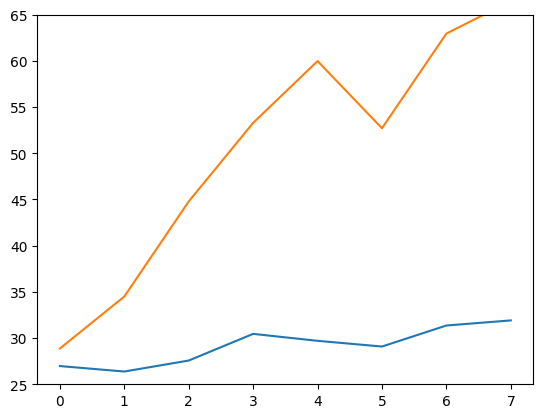

In [15]:
held_out_days_big_dict = pd.read_pickle('/home3/ebrahim/paper_results_wer/transformer_shortened_held_out_days_big_diet64corp.pkl')
averaged_held_out_days_big_dict = np.mean(np.array(list(held_out_days_big_dict.values())), axis=0)
baseline_held_out_days_big_dict = pd.read_pickle('/home3/ebrahim/paper_results_wer/transformer_shortened_held_out_days_big_baseline.pkl')
averaged_baseline_held_out_days_big_dict = np.mean(np.array(list(baseline_held_out_days_big_dict.values())), axis=0)
plt.plot(averaged_held_out_days_big_dict*100)
plt.plot(averaged_baseline_held_out_days_big_dict*100)
plt.ylim(25,65)

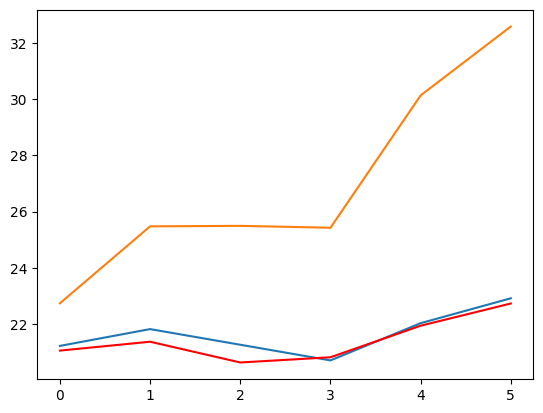

In [29]:
held_out_days_dict = pd.read_pickle('/home3/ebrahim/paper_results_wer/transformer_short_held_out_normal_diet64corp.pkl')
held_out_days_dict_1e3 = pd.read_pickle('/home3/ebrahim/paper_results_wer/transformer_short_held_out_normal_diet64corp1e3.pkl')
averaged_held_out_days_dict = np.mean(np.array(list(held_out_days_dict.values())), axis=0)
averaged_held_out_days_dict_1e3 = np.mean(np.array(list(held_out_days_dict_1e3.values())), axis=0)
baseline_held_out_days_dict = pd.read_pickle('/home3/ebrahim/paper_results_wer/transformer_short_held_out_normal_baseline.pkl')
averaged_baseline_held_out_days_dict = np.mean(np.array(list(baseline_held_out_days_dict.values())), axis=0)
plt.plot(averaged_held_out_days_dict*100)
plt.plot(averaged_held_out_days_dict_1e3*100, color='red')
plt.plot(averaged_baseline_held_out_days_dict*100)

In [25]:
print(averaged_baseline_held_out_days_dict)
print(averaged_held_out_days_dict)

[0.22741636 0.25476917 0.25494206 0.25427033 0.30130807 0.32582062]
[0.21226766 0.21823731 0.21267894 0.20711103 0.22034281 0.22919556]
